In [61]:
import praw
import matplotlib.pyplot as plt
import datetime
from praw.models import MoreComments
import pandas as pd
from langdetect import detect
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import CoherenceModel, LdaModel
import gensim.corpora as corpora
import pyLDAvis.gensim_models
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Download nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
# Initialize Reddit API instance
reddit = praw.Reddit(client_id='secret',
                     client_secret='secret',
                     user_agent='MyRedditScraper by /u/reddit',
                     username='username',
                     password='password')

In [ ]:
# URLs of the Reddit posts
post_urls = [
    "https://www.reddit.com/r/vfx/comments/1arn9t5/open_ai_announces_sora_text_to_video_ai_generation/",
    "https://www.reddit.com/r/singularity/comments/1arm2g5/introducing_sora_our_texttovideo_model_openai/",
    "https://www.reddit.com/r/blender/comments/1as871w/lets_talk_about_sora_by_openai/",
    "https://www.reddit.com/r/redscarepod/comments/1arummz/this_sora_ai_stuff_is_awful/",
    "https://www.reddit.com/r/ChatGPT/comments/1arm7rf/sora_by_openai_looks_incredible_txt_to_video/",
    "https://www.reddit.com/r/singularity/comments/1armkty/video_generated_with_openais_sora_hard_to_wrap/",
    "https://www.reddit.com/r/technology/comments/1blbui7/openai_is_pitching_sora_to_hollywood/",
    "https://www.reddit.com/r/OpenAI/comments/1arm4ff/things_are_moving_way_too_fast_openai_on_x/",
    "https://www.reddit.com/r/news/comments/1asft9a/openai_teases_sora_its_new_texttovideo_ai_model/",
    "https://www.reddit.com/r/technology/comments/1asfrh9/openai_collapses_media_reality_with_sora_ai_video/"
]

dataset = []

def preprocess_text(text):
    # Remove non-English characters and symbols
    english_text = ''.join(char for char in text if char.isascii())
    return english_text

def get_top_comments(submission, num_comments=200):
    submission.comments.replace_more(limit=None)
    comments = submission.comments.list()
    comments.sort(key=lambda x: x.score, reverse=True)
    
    for comment in comments[:num_comments]:
        if isinstance(comment, MoreComments):
            continue
        if comment.author and comment.author.name != '[deleted]':  # Skip deleted authors
            author = comment.author.name
            text = preprocess_text(comment.body)
            # Detect the language of the text
            try:
                language = detect(text)
                if language == 'en':  # Only include English text
                    date = comment.created_utc
                    score = comment.score
                    subreddit_source = comment.subreddit.display_name
                    post_title = submission.title
                    post_author_id = submission.author.id
                    # Handle the case where the author's unique ID cannot be retrieved
                    try:
                        author_id = comment.author.id
                    except AttributeError:
                        author_id = None
                    # Add the comment to the data list
                    dataset.append([author, text, date, score, post_title, post_author_id, author_id, subreddit_source])
            except Exception as e:
                pass  

# Retrieve top comments from each of the submissions
for post_url in post_urls:
    submission = reddit.submission(url=post_url)
    get_top_comments(submission)

# Create a pandas DataFrame from the data
dataframe = pd.DataFrame(dataset, columns=['Author', 'Text', 'Date', 'Score', 'Post_Title', 'Post_Author_ID', 'Author_ID', 'Subreddit'])
dataframe.to_csv('reddit_data_sora.csv', index=False)

In [65]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Author             1827 non-null   object        
 1   Text               1827 non-null   object        
 2   Date               1827 non-null   datetime64[ns]
 3   Score              1827 non-null   int64         
 4   Post_Title         1827 non-null   object        
 5   Post_Author_ID     1827 non-null   object        
 6   Author_ID          1827 non-null   object        
 7   Subreddit          1827 non-null   object        
 8   Preprocessed_Text  1827 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 128.6+ KB


In [66]:
# Sort the comments based on their score
dataframe = dataframe.sort_values(by='Score', ascending=False)

# Fill missing values of author_id with 'deleted'
dataframe['Author_ID'] = dataframe['Author_ID'].fillna('deleted')

In [67]:
# Read the CSV file into a DataFrame
dataframe = pd.read_csv('reddit_data_sora.csv')
dataframe['Date'] = pd.to_datetime(dataframe['Date'], unit='s')

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters and URLs
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # Remove specific words
    text = re.sub(r'\b(?:http|www|com)\b', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Join tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text


# Apply preprocessing to the 'Text' column
dataframe['Preprocessed_Text'] = dataframe['Text'].apply(preprocess_text)

# Display the preprocessed DataFrame
dataframe.head()

[nltk_data] Downloading package punkt to C:\Users\HRISHIKESH DIPAK
[nltk_data]     PARIKH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\HRISHIKESH DIPAK
[nltk_data]     PARIKH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\HRISHIKESH DIPAK
[nltk_data]     PARIKH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Author,Text,Date,Score,Post_Title,Post_Author_ID,Author_ID,Subreddit,Preprocessed_Text
0,MichaelJosephGFX,I will still keep pushing and extruding vertic...,2024-02-16 14:44:39,1237,Let's talk about Sora by OpenAI...,gtvbabsm,c7x1zzev,blender,still keep pushing extruding vertex enjoy maki...
1,Zugas,Make it watch GoT and do a remake of the last ...,2024-02-16 20:13:33,822,OpenAI collapses media reality with Sora AI vi...,6d0w1,ali44,technology,make watch got remake last season
2,cluele55cat,as a person who works in the film industry. \n...,2024-02-15 20:11:09,700,Sora by openAI looks incredible (txt to video),z6l1l,g32t2krg,ChatGPT,person work film industry fuck
3,white_einstein,The more the individual creative instinct is s...,2024-02-16 00:44:19,666,This Sora AI stuff is awful,fredzpq9b,demnj6qsg,redscarepod,individual creative instinct stifled human cre...
4,wntersnw,The demos on the official announcement are min...,2024-02-15 18:22:27,634,"Introducing Sora, our text-to-video model Open...",5snahzy,v4r6rwr0,singularity,demo official announcement mind blowing felt f...


In [124]:
dataframe.head(10)
dataframe.to_csv('reddit_data_sora_preprocessed.csv', index=False)

In [83]:
# Tokenize the preprocessed text
tokenized_text = [word_tokenize(text) for text in dataframe['Preprocessed_Text']]

# Create dictionary and corpus
id2word = gensim.corpora.Dictionary(tokenized_text)
corpus = [id2word.doc2bow(text) for text in tokenized_text]

# Compute coherence values for different numbers of topics
coherence_values = []
model_list = []
for num_topics in range(2, 11):  # Test different numbers of topics
    classifier = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    model_list.append(classifier)
    coherencemodel = CoherenceModel(classifier=classifier, texts=tokenized_text, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Find the optimal number of topics with the highest coherence score
optimal_num_topics = coherence_values.index(max(coherence_values)) + 2  # Adding 2 because we started from 2 topics
print("Optimal number of topics based on the highest coherence score:", optimal_num_topics)

# Build the LDA model with the optimal number of topics
optimal_model = model_list[optimal_num_topics - 2]  # Getting the classifier with optimal number of topics

Optimal number of topics based on the highest coherence score: 4


In [125]:
# Define topic titles
topic_titles = {
    0: "AI Impact and Trends in Sora Discussions",
    1: "Public Opinion and Concerns about Sora",
    2: "Artistic Expression and Video Creation with Sora",
    3: "Sora's Applications in Media and Entertainment"
}

# Get the most relevant words for each topic
topics = optimal_model.show_topics(formatted=False)

# Print the most relevant words for each topic with titles
for topic_num, words in topics:
    print(f"Topic {topic_num}: {topic_titles[topic_num]}")
    for word, score in words:
        print(f"{word} (Score: {score:.4f})")
    print("\n")


Topic 0: AI Impact and Trends in Sora Discussions
ai (Score: 0.0200)
people (Score: 0.0111)
going (Score: 0.0074)
year (Score: 0.0072)
get (Score: 0.0071)
like (Score: 0.0066)
think (Score: 0.0055)
thing (Score: 0.0055)
job (Score: 0.0046)
artist (Score: 0.0045)


Topic 1: Public Opinion and Concerns about Sora
people (Score: 0.0109)
ai (Score: 0.0107)
think (Score: 0.0098)
like (Score: 0.0076)
year (Score: 0.0074)
need (Score: 0.0056)
want (Score: 0.0050)
video (Score: 0.0049)
even (Score: 0.0046)
one (Score: 0.0044)


Topic 2: Artistic Expression and Video Creation with Sora
ai (Score: 0.0203)
like (Score: 0.0095)
art (Score: 0.0087)
video (Score: 0.0087)
people (Score: 0.0078)
get (Score: 0.0064)
make (Score: 0.0062)
artist (Score: 0.0050)
time (Score: 0.0049)
going (Score: 0.0048)


Topic 3: Sora's Applications in Media and Entertainment
ai (Score: 0.0144)
people (Score: 0.0117)
like (Score: 0.0089)
make (Score: 0.0083)
video (Score: 0.0078)
model (Score: 0.0056)
one (Score: 0.0056

C:\Users\HRISHIKESH DIPAK DESAI\AppData\Local\Temp\ipykernel_8016\2083005899.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topic['word'], rotation=30, horizontalalignment='right')


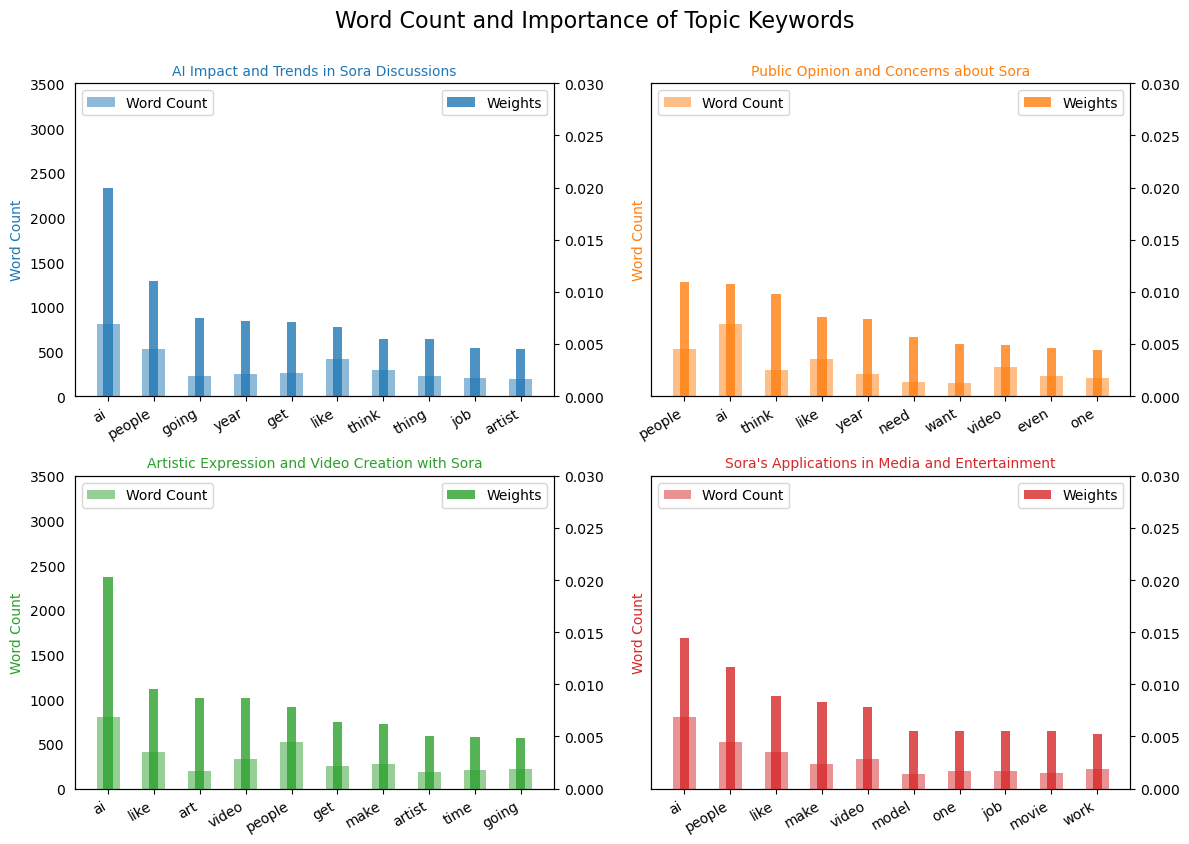

In [115]:
# Get topics from the LDA modeltopics = optimal_model.show_topics(formatted=False)# Flatten the datadata_flat = [word for word_list in tokenized_text for word in word_list]# Count word occurrencescounter = Counter(data_flat)# Initialize an empty list to store the dataout = []# Iterate over topicsfor topic_num, words in topics:    # Iterate over words and their weights in the topic    for word, weight in words:        # Append word, topic ID, importance (weight), and word count to the list        out.append([word, topic_num, weight, counter[word]])# Create a DataFrame from the datadf_word_count_importance = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        # Plot Word Count and Weights of Topic Keywordsfig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=100, sharey=True)cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]for i, ax in enumerate(axes.flatten()):    df_topic = df_word_count_importance[df_word_count_importance['topic_id'] == i]    ax.bar(x='word', height="word_count", data=df_topic, color=cols[i], width=0.5, alpha=0.5, label='Word Count')    ax_twin = ax.twinx()    ax_twin.bar(x='word', height="importance", data=df_topic, color=cols[i], width=0.2, alpha=0.8, label='Weights')    ax.set_ylabel('Word Count', color=cols[i])    ax_twin.set_ylim(0, 0.030)    ax.set_ylim(0, 3500)    ax.set_title(topic_titles[i], color=cols[i], fontsize=10)    ax.tick_params(axis='target', left=False)    ax.set_xticklabels(df_topic['word'], rotation=30, horizontalalignment='right')    ax.legend(loc='upper left')    ax_twin.legend(loc='upper right')fig.tight_layout(w_pad=2)    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=16, y=1.05)    plt.show()

In [95]:
# Create a dictionary representation of the documents
dictionary = Dictionary(preprocessed_texts)

# Filter out words that occur in less than 20 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.018163 -0.008551       1        1  30.159674
3     -0.025445 -0.018316       2        1  25.604764
2      0.016366 -0.002619       3        1  24.338982
1     -0.009085  0.029486       4        1  19.896580, topic_info=      Term        Freq       Total Category  logprob  loglift
46    year  243.000000  243.000000  Default  30.0000  30.0000
13      ai  796.000000  796.000000  Default  29.0000  29.0000
159  would  185.000000  185.000000  Default  28.0000  28.0000
155  think  288.000000  288.000000  Default  27.0000  27.0000
93    time  209.000000  209.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
84     get   34.064235  255.420523   Topic4  -4.9067  -0.4000
6     make   33.587728  266.664207   Topic4  -4.9208  -0.4572
69    even   31.049500  218.749465   Topic4  -4.9993  -0.3377
125    job   30.123394  193.103157   Topic4  -5.0296  -0.2433
14     art   29.820534  197.195260   Topic4  -5.0397  -0.2744

[261 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
47        1  0.151535     1
47        2  0.454606     1
47        3  0.269396     1
47        4  0.117861     1
311       1  0.262040   100
...     ...       ...   ...
293       4  0.127248  yeah
46        1  0.086361  year
46        2  0.242634  year
46        3  0.320770  year
46        4  0.353670  year

[660 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

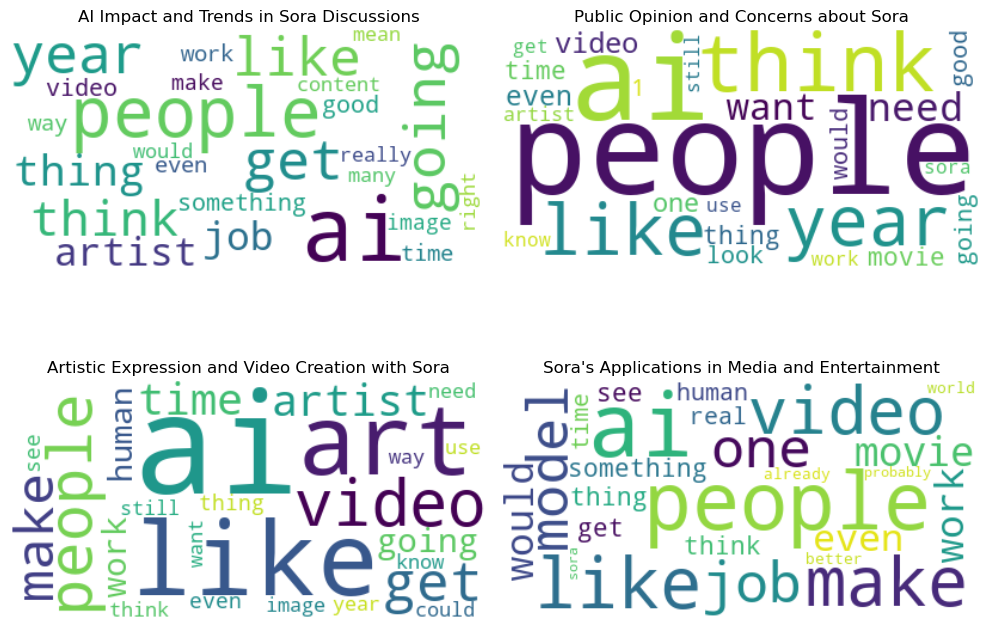

In [120]:
# Create subplots for 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate over each topic
for idx, ax in enumerate(axs.flat):
    # Get words and scores for the current topic
    topic_words = dict(optimal_model.show_topic(idx, topn=25))  
    # Generate word cloud for the current topic
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(topic_words)
    # Plot word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(topic_titles[idx]) 
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [131]:
# Get topic weightstopic_weights = []for i, row_list in enumerate(lda_model[corpus]):    topic_weights.append([w[1] for w in row_list])# Array of topic weights    arr = pd.DataFrame(topic_weights).fillna(0).values# Keep the well-separated points (optional)arr = arr[np.amax(arr, axis=1) > 0.35]# Dominant topic number in each doctopic_num = np.argmax(arr, axis=1)# tSNE Dimension Reductiontsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')tsne_lda = tsne_model.fit_transform(arr)# Plot the Topic Clusters using Bokehoutput_notebook()n_clusters = 4  # Change to 4 for 4 clustersmycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_clusters),               width=900, height=700)  # Corrected attribute# Define the clusters based on the dominant topicscluster_colors = [mycolors[i] for i in topic_num]plot.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1], color=cluster_colors)show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1767 samples in 0.001s...
[t-SNE] Computed neighbors for 1767 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1767
[t-SNE] Computed conditional probabilities for sample 1767 / 1767
[t-SNE] Mean sigma: 0.007888
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.552635
[t-SNE] KL divergence after 1000 iterations: 0.241204


Loading BokehJS ...

In [127]:
# Initialize an empty dictionary to store relevance scores for each word
word_scores = {i: {} for i in range(len(topics))}

# Iterate over topics
for topic_num, words in topics:
    # Calculate the total relevance score for all words in the topic
    total_score = sum(score for word, score in words)
    # Calculate the average relevance score for the topic
    average_score = total_score / len(words)
    
    # Store the average relevance score for each word in the topic
    for word, score in words:
        word_scores[topic_num][word] = score

# Calculate the highest average relevance score for each topic
highest_average_score = {}
for topic_num, scores in word_scores.items():
    highest_average_score[topic_num] = max(scores.values())

# Print the highest average relevance score for each topic
for topic_num, score in highest_average_score.items():
    print(f"Topic {topic_num}: Highest Average Score: {score}")


Topic 0: Highest Average Score: 0.019962163642048836
Topic 1: Highest Average Score: 0.010915854945778847
Topic 2: Highest Average Score: 0.020311281085014343
Topic 3: Highest Average Score: 0.014416816644370556


In [132]:
# Define the topic titles or labels
topic_titles = {
    0: "AI Impact and Trends in Sora Discussions",
    1: "Public Opinion and Concerns about Sora",
    2: "Artistic Expression and Video Creation with Sora",
    3: "Sora's Applications in Media and Entertainment"
}

# Get the dominant topic number for each comment
topic_num = np.argmax(arr, axis=1)

# Map the topic number to its corresponding title or label
topic_labels = [topic_titles[i] for i in topic_num]

# Get unique colors used in the plot
unique_colors = list(set(cluster_colors))

# Print the mapping of colors to topics
for color in unique_colors:
    topic_index = cluster_colors.index(color)
    topic = topic_labels[topic_index]
    print(f"Color {color} represents topic: {topic}")


Color #d62728 represents topic: Sora's Applications in Media and Entertainment
Color #1f77b4 represents topic: AI Impact and Trends in Sora Discussions
Color #2ca02c represents topic: Artistic Expression and Video Creation with Sora
Color #ff7f0e represents topic: Public Opinion and Concerns about Sora
